In [1]:
!pip install -q kaggle

In [5]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c ucsc-cse-164-spring-2024-final-project

100% 1.04G/1.04G [01:08<00:00, 18.5MB/s]
100% 1.04G/1.04G [01:08<00:00, 16.3MB/s]


In [8]:
!unzip -q ucsc-cse-164-spring-2024-final-project.zip

In [7]:
import os
from skimage import io
import csv
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np
%matplotlib inline

In [61]:
# Load the CSV file
csv_path = 'train_labeled.csv'
data = pd.read_csv(csv_path)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Calculate the number of rows for each split
total_rows = len(data)
train_rows = int(total_rows * 0.9)
test_rows = total_rows - train_rows

# Split the data into two parts
train_data = data.iloc[:train_rows]
test_data = data.iloc[train_rows:]

# Save the split data to new CSV files
train_csv_path = 'train_data.csv'
test_csv_path = 'val_data.csv'

train_data.to_csv(train_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)

In [10]:
# RESOLUTION = 364

train_transform = transforms.Compose([
    transforms.Resize(256),  # Resize the shorter side to 256 pixels
    transforms.CenterCrop(224),  # Crop the center 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    v2.ColorJitter(),
    v2.RandomRotation(degrees=[-10,10]),
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor with mean and std
                         std=[0.229, 0.224, 0.225]),
])

# Define a transform for the validation data without data augmentation
val_transform = transforms.Compose([
    transforms.Resize(256),  # Resize the shorter side to 256 pixels
    transforms.CenterCrop(224),  # Crop the center 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor with mean and std
                         std=[0.229, 0.224, 0.225]),
])

In [62]:
train_csv = 'train_data.csv'
val_csv = 'val_data.csv'
labeled_path = 'train/labeled'

class CustomDataset(Dataset):
    def __init__(self, csv_file, train_path, transform=None):
        self.train_labeled = train_path
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.pseudo_label_data = []

    def __len__(self):
        return len(self.df) + len(self.pseudo_label_data)

    def add_psudo_data(self, data):
        self.pseudo_label_data.extend(data)

    def __getitem__(self, idx):
        if idx < len(self.df):
            img_path = self.train_labeled + '/' + self.df.image[idx]
            image = datasets.folder.default_loader(img_path)
            label = self.df.id[idx]
        else:
            image = datasets.folder.default_loader(self.pseudo_label_data[idx-len(self.df)][1])
            label = int(self.pseudo_label_data[idx-len(self.df)][0])
        if self.transform:
            image = self.transform(image)

        return image, label
labeled_train_dataset = CustomDataset(train_csv, labeled_path, train_transform)
labeled_val_dataset = CustomDataset(val_csv, labeled_path, val_transform)

In [12]:
print(labeled_train_dataset.df['id'][labeled_train_dataset.df['id'] >= 15].count())
(labeled_train_dataset.df['id'][labeled_train_dataset.df['id'] < 15].count())

4513


4355

In [13]:
print(len(labeled_train_dataset), len(labeled_val_dataset))

8868 986


In [14]:
BATCH_SIZE = 32
train_label_loader = DataLoader(dataset=labeled_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_label_loader = DataLoader(dataset=labeled_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

tensor(6)


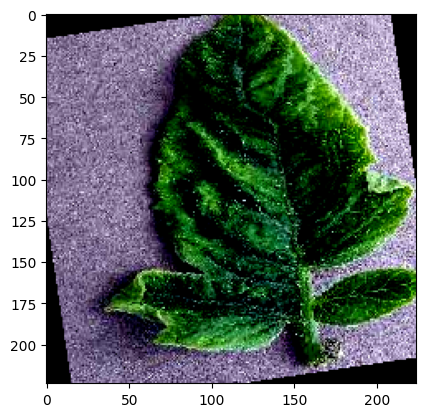

In [ ]:
def imshow(img, un):
    if(un):
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_iter = iter(train_label_loader)
images, labels = next(train_iter)
print(labels[0])
imshow(make_grid(images[0]), True)

In [45]:
unlabeled_path = 'train/unlabeled'

# For the test set, since there are no labels, we need to create a custom DataSet.
class UnlabeledDataset(datasets.VisionDataset):
    def __init__(self, root, transform=None):
        super(UnlabeledDataset, self).__init__(root, transform=transform)
        self.images = [os.path.join(root, img) for img in os.listdir(root)]

    def __getitem__(self, index):
        image_path = self.images[index]
        image = datasets.folder.default_loader(image_path)  # default loader is PIL.Image.open
        if self.transform:
            image = self.transform(image)
        return image, str(image_path)

    def __len__(self):
        return len(self.images)
    # def remove_from_ds(image_path):



# Create a dataset for your test data
unlabeled_ds = UnlabeledDataset(root=unlabeled_path, transform=val_transform)

# Create a DataLoader for your test set
unlabel_loader = DataLoader(dataset=unlabeled_ds, batch_size=BATCH_SIZE, shuffle=True)
print(len(unlabeled_ds))

22995


In [96]:
from torchvision.models import resnet50
model_shuffle = resnet50()

In [97]:
class ModifiedResNet101(nn.Module):
    def __init__(self, model_conv):
        super(ModifiedResNet101, self).__init__()
        self.model = model_conv

        self.new_head = nn.Sequential(
            nn.Linear(1000, 135),
        )

    def forward(self, x):
        x = self.model(x)
        x = self.new_head(x)
        return x

# Create the modified model
model = ModifiedResNet101(model_shuffle)

In [44]:
# model.load_state_dict(torch.load('ResNet50.pt'))

In [46]:
def eval_unlabeled_data(model, dataloader, device, thrs = 0.7):
    dog_data = []
    leaves_data = []
    psudo_data = []
    model.eval()
    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as vepoch:
            for images, path in vepoch:
                vepoch.set_description(f"Unlabeled Epoch")
                images = images.to(device)
                outputs = model(images)
                probs = nn.Softmax(dim=1)
                probs = probs(outputs)
                max_probs, targets = torch.max(probs, dim=1)
                mask = max_probs > thrs
                for i in range(len(targets)):
                    target = targets[i].item()
                    if target < 15 and mask[i]:
                        leaves_data.append((target, path[i]))
                    elif mask[i]:
                        dog_data.append((target, path[i]))
        if len(leaves_data)  > len(dog_data):
            leaves_data = leaves_data[:int(len(dog_data))]
        psudo_data.extend(leaves_data)
        psudo_data.extend(dog_data)
        random.shuffle(psudo_data)
        print('num dogs added', len(dog_data))
    return psudo_data

In [48]:
# len(dog), len(leave)

In [99]:
torch.cuda.empty_cache()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
max_val_acc = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print()

In [100]:
pd.set_option('display.max_rows', 135)
class_counts = labeled_train_dataset.df['id'].value_counts()
c = class_counts.sort_index()
class_counts = c.to_numpy()
class_counts = np.insert(class_counts, 56, 0)
total_samples = len(labeled_train_dataset)
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
class_weights[56] = .001
class_weights

<ipython-input-100-e4f721721e68>:7: RuntimeWarning: divide by zero encountered in scalar divide
  class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]


tensor([2.1608e-01, 3.1132e-01, 1.7706e-01, 2.1896e+00, 1.5312e-01, 7.3808e-01,
        9.3308e-02, 2.0854e-01, 3.2200e-01, 1.9550e-01, 2.9457e-01, 3.2519e-01,
        1.7470e-01, 3.0271e-01, 1.8715e-01, 1.5640e+00, 1.0427e+00, 1.5276e+00,
        1.8768e+00, 1.6022e+00, 2.3460e+00, 2.3460e+00, 1.9906e+00, 1.6022e+00,
        2.1190e+00, 1.1943e+00, 1.6022e+00, 2.3460e+00, 2.2651e+00, 1.9906e+00,
        2.0528e+00, 1.8768e+00, 1.6422e+00, 1.9906e+00, 2.1190e+00, 1.8247e+00,
        1.7754e+00, 2.3460e+00, 1.4598e+00, 1.8768e+00, 2.1190e+00, 1.4280e+00,
        1.4929e+00, 1.8768e+00, 2.1190e+00, 1.2165e+00, 2.3460e+00, 9.2520e-01,
        1.3685e+00, 1.7287e+00, 2.2651e+00, 2.4329e+00, 1.1943e+00, 1.8768e+00,
        2.5265e+00, 1.3685e+00, 1.0000e-03, 2.1896e+00, 1.8247e+00, 2.4329e+00,
        2.1896e+00, 1.9320e+00, 1.3685e+00, 1.6422e+00, 1.4929e+00, 1.8768e+00,
        2.0528e+00, 2.1190e+00, 1.8247e+00, 1.8247e+00, 1.3685e+00, 2.2651e+00,
        1.9906e+00, 1.3976e+00, 1.8768e+

In [101]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

In [ ]:
num_epochs = 50

# Lists for tracking loss and accuracy
i = 0
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterate over the training set
    with tqdm(train_label_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update progress bar
            tepoch.set_postfix(loss=(running_loss / total_predictions), accuracy=(correct_predictions / total_predictions))

    # Calculate and print loss and accuracy for the training phase
    epoch_loss = running_loss / len(train_label_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()  # Set the model to evaluation mode

    # Run inference on unlabeled data and add to labeled dataset
    print(i)
    if i > 14:
        data = eval_unlabeled_data(model, unlabel_loader, device)
        labeled_train_dataset.add_psudo_data(data)
        print('new ds len', len(labeled_train_dataset))
        train_label_loader = DataLoader(dataset=labeled_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        # Remove data that has been given pseudo labels from our unlabeled dataset
        set_data = set([x[1] for x in data])
        unlabeled_ds.images = [x for x in unlabeled_ds.images if x not in set_data]
        print('new unlabled ds len', len(unlabeled_ds.images))
        unlabel_loader = DataLoader(dataset=unlabeled_ds, batch_size=BATCH_SIZE, shuffle=True)
    i += 1
    # Validation phase
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    # Disable gradient calculation for validation to save memory and computations
    with torch.no_grad():
        with tqdm(val_label_loader, unit="batch") as vepoch:
            for images, labels in vepoch:
                vepoch.set_description(f"Validation Epoch {epoch+1}/{num_epochs}")

                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

                # Update progress bar
                vepoch.set_postfix(val_loss=(val_running_loss / val_total_predictions), val_accuracy=(val_correct_predictions / val_total_predictions))

    # Calculate and print loss and accuracy for the validation phase
    val_epoch_loss = val_running_loss / len(val_label_loader.dataset)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    if val_epoch_accuracy > max_val_acc:
        torch.save(model.state_dict(), 'ResNet50.pt')

    # Print summary for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

Epoch 1/50: 100%|██████████| 278/278 [02:04<00:00,  2.23batch/s, accuracy=0.0265, loss=4.96]


0


Validation Epoch 1/50: 100%|██████████| 31/31 [00:06<00:00,  4.73batch/s, val_accuracy=0.00406, val_loss=4.88]


Epoch [1/50], Train Loss: 4.9637, Train Accuracy: 0.0265, Val Loss: 4.8801, Val Accuracy: 0.0041


Epoch 2/50: 100%|██████████| 278/278 [02:05<00:00,  2.21batch/s, accuracy=0.0454, loss=4.68]


1


Validation Epoch 2/50: 100%|██████████| 31/31 [00:06<00:00,  5.15batch/s, val_accuracy=0.0588, val_loss=4.59]


Epoch [2/50], Train Loss: 4.6777, Train Accuracy: 0.0454, Val Loss: 4.5945, Val Accuracy: 0.0588


Epoch 3/50: 100%|██████████| 278/278 [02:04<00:00,  2.23batch/s, accuracy=0.0666, loss=4.55]


2


Validation Epoch 3/50: 100%|██████████| 31/31 [00:05<00:00,  5.21batch/s, val_accuracy=0.0852, val_loss=4.48]


Epoch [3/50], Train Loss: 4.5550, Train Accuracy: 0.0666, Val Loss: 4.4839, Val Accuracy: 0.0852


Epoch 4/50: 100%|██████████| 278/278 [02:05<00:00,  2.22batch/s, accuracy=0.125, loss=4.42]


3


Validation Epoch 4/50: 100%|██████████| 31/31 [00:05<00:00,  5.30batch/s, val_accuracy=0.118, val_loss=4.44]


Epoch [4/50], Train Loss: 4.4183, Train Accuracy: 0.1252, Val Loss: 4.4379, Val Accuracy: 0.1176


Epoch 5/50: 100%|██████████| 278/278 [02:04<00:00,  2.23batch/s, accuracy=0.151, loss=4.34]


4


Validation Epoch 5/50: 100%|██████████| 31/31 [00:05<00:00,  5.26batch/s, val_accuracy=0.184, val_loss=4.29]


Epoch [5/50], Train Loss: 4.3350, Train Accuracy: 0.1511, Val Loss: 4.2938, Val Accuracy: 0.1836


Epoch 6/50: 100%|██████████| 278/278 [02:03<00:00,  2.25batch/s, accuracy=0.18, loss=4.28]


5


Validation Epoch 6/50: 100%|██████████| 31/31 [00:05<00:00,  5.30batch/s, val_accuracy=0.159, val_loss=4.3]


Epoch [6/50], Train Loss: 4.2766, Train Accuracy: 0.1795, Val Loss: 4.2971, Val Accuracy: 0.1592


Epoch 7/50: 100%|██████████| 278/278 [02:04<00:00,  2.24batch/s, accuracy=0.204, loss=4.22]


6


Validation Epoch 7/50: 100%|██████████| 31/31 [00:05<00:00,  5.26batch/s, val_accuracy=0.192, val_loss=4.25]


Epoch [7/50], Train Loss: 4.2187, Train Accuracy: 0.2043, Val Loss: 4.2491, Val Accuracy: 0.1917


Epoch 8/50: 100%|██████████| 278/278 [02:03<00:00,  2.25batch/s, accuracy=0.214, loss=4.19]


7


Validation Epoch 8/50: 100%|██████████| 31/31 [00:05<00:00,  5.28batch/s, val_accuracy=0.129, val_loss=8.26]


Epoch [8/50], Train Loss: 4.1911, Train Accuracy: 0.2137, Val Loss: 8.2588, Val Accuracy: 0.1288


Epoch 9/50: 100%|██████████| 278/278 [02:03<00:00,  2.25batch/s, accuracy=0.219, loss=4.13]


8


Validation Epoch 9/50: 100%|██████████| 31/31 [00:05<00:00,  5.28batch/s, val_accuracy=0.236, val_loss=4.62]


Epoch [9/50], Train Loss: 4.1348, Train Accuracy: 0.2190, Val Loss: 4.6224, Val Accuracy: 0.2363


Epoch 10/50: 100%|██████████| 278/278 [02:03<00:00,  2.25batch/s, accuracy=0.235, loss=4.09]


9


Validation Epoch 10/50: 100%|██████████| 31/31 [00:06<00:00,  5.13batch/s, val_accuracy=0.253, val_loss=4.19]


Epoch [10/50], Train Loss: 4.0897, Train Accuracy: 0.2349, Val Loss: 4.1930, Val Accuracy: 0.2525


Epoch 11/50: 100%|██████████| 278/278 [02:02<00:00,  2.27batch/s, accuracy=0.235, loss=4.03]


10


Validation Epoch 11/50: 100%|██████████| 31/31 [00:06<00:00,  5.09batch/s, val_accuracy=0.253, val_loss=4.23]


Epoch [11/50], Train Loss: 4.0279, Train Accuracy: 0.2353, Val Loss: 4.2328, Val Accuracy: 0.2525


Epoch 12/50: 100%|██████████| 278/278 [02:02<00:00,  2.26batch/s, accuracy=0.254, loss=3.97]


11


Validation Epoch 12/50: 100%|██████████| 31/31 [00:06<00:00,  5.10batch/s, val_accuracy=0.214, val_loss=4.17]


Epoch [12/50], Train Loss: 3.9739, Train Accuracy: 0.2538, Val Loss: 4.1679, Val Accuracy: 0.2140


Epoch 13/50:   6%|▌         | 17/278 [00:07<01:52,  2.32batch/s, accuracy=0.244, loss=3.88]

0
16     831
41     582
121    570
6      472
4      333
14     225
2      221
9      213
7      204
12     175
0      162
10     154
11     144
8      114
1      112
17     108
64     104
62      97
66      85
89      79
13      76
130     72
5       53
101     48
123     34
3       18
70      11
107      9
102      7
75       5
97       4
34       4
128      3
105      3
134      3
42       3
85       2
72       2
28       2
65       2
67       1
71       1
88       1
21       1
103      1
47       1
Name: count, dtype: int64

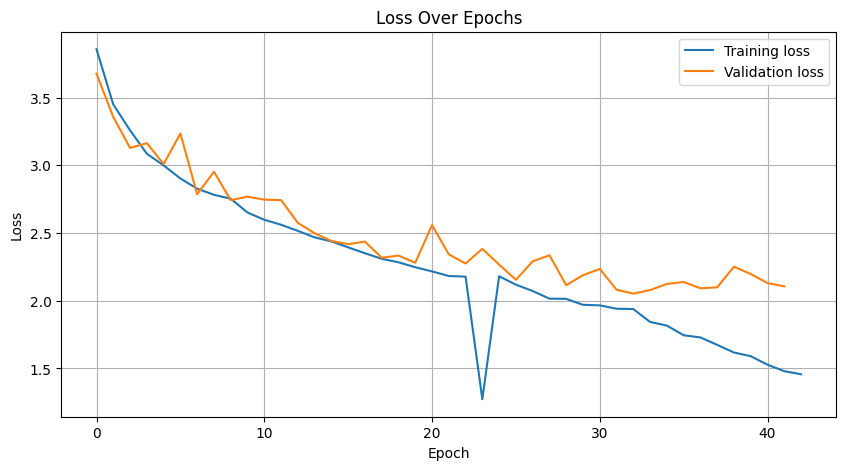

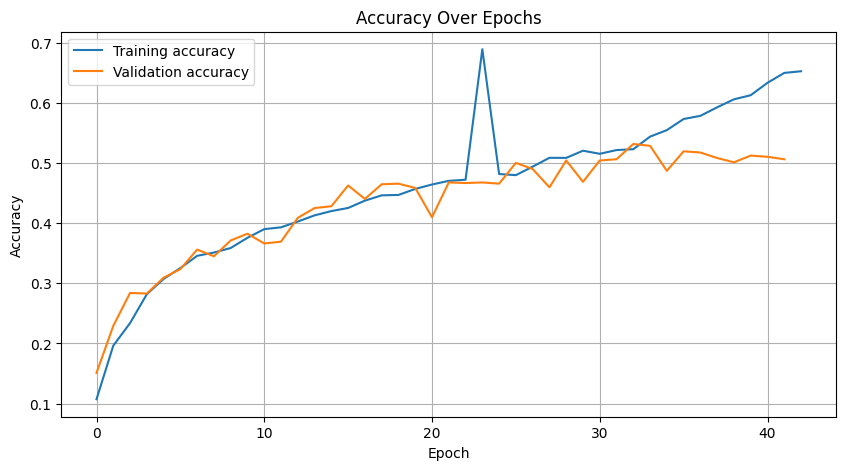

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_dir = 'test'

# For the test set, since there are no labels, we need to create a custom DataSet.
class TestDataset(datasets.VisionDataset):
    def __init__(self, root, transform=None):
        super(TestDataset, self).__init__(root, transform=transform)
        self.images = [os.path.join(root, img) for img in os.listdir(root)]

    def __getitem__(self, index):
        image_path = self.images[index]
        image = datasets.folder.default_loader(image_path)  # default loader is PIL.Image.open
        if self.transform:
            image = self.transform(image)
        return image, str(image_path)

    def __len__(self):
        return len(self.images)

# Create a dataset for your test data
test_dataset = TestDataset(root=test_dir, transform=val_transform)

# Create a DataLoader for your test set
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Model's evaluation mode
model.load_state_dict(torch.load('ResNet50.pt'))
model.to(device)

# Put the model in evaluation mode
model.eval()

test_predictions = []

# Assuming the model is already in evaluation mode and device is defined
with torch.no_grad():
    for images, paths in tqdm(test_loader, desc='Predicting labels'):
        images = images.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Go through the batch and add to our prediction list, including image paths
        for path, label in zip(paths, predicted):
            test_predictions.append((Path(path).name, label))  # Appending a tuple of filename and label

with open('test_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image', 'id'])
    writer.writerows(test_predictions)  # Writing all predictions at once

Predicting labels: 100%|██████████| 257/257 [01:35<00:00,  2.70it/s]


In [ ]:
import re

m = re.search('\(([^\)]+)\)', 'ab(c)def')
m.group(0)

df = pd.read_csv('test_predictions.csv')
new_col = df['id'][0]
new_col[new_col.find("(")+1:new_col.find(",")]

for i in range(len(df['id'])):
    val = df['id'][i]
    val = val[val.find("(")+1:val.find(",")]
    df['id'][i] = val
df.to_csv('pred.csv', index=False)